In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import  pickle

In [2]:
import sys
sys.path.append("./src")
from evals import *
from optimization import *
from gauss_update import *
from gaussian_process import *
from kinetic_model import *
from mpc import *

### Load waypoints

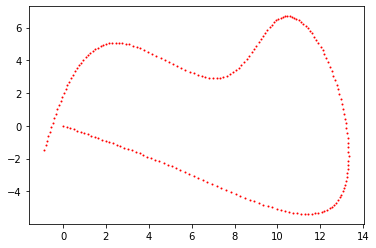

In [3]:
with open('./data/waypoints.binaryfile', 'rb') as td:
    waypoints = pickle.load(td)
    
cx,cy = waypoints[:,0],waypoints[:,1]
plt.scatter(cx,cy,color='red',s=1)

### Load training data (59 records collected using inaccurate dynamics model)

In [4]:
import  pickle
with open('./data/training_data.binaryfile', 'rb') as td:
    data = pickle.load(td)
pos = torch.cat([d[0].view(1,-1) for d in data ] , dim=0)
label = torch.cat([d[1].view(1,-1) for d in data ] , dim=0)
pred = torch.cat([d[2].view(1,-1) for d in data ] , dim=0)
cont_dt = torch.cat([d[3].view(1,-1) for d in data ] , dim=0)
x = torch.cat([pos[:,2:],cont_dt[:,:-1]],dim=1)
label_ = label[:,2:4]
pred_ = pred[:,2:4]
y = (label_ - pred_)

### train Gaussian-Process

In [5]:
gp_model = GaussianProcess(dim_x=6,dim_y=2,var=0.01)
gp_model.train(x,y)

### define process-model(inaccurate) and acutual-car-model

In [6]:
# inaccurate process_model
p_model = vehicle_model(WB=2.5) 

# actual_car_model
real_car_model = vehicle_model(WB=1.5)

### Run MPC

In [7]:
len_horizon = 10
TMAX = 200
step = 0
sigma_w = 0.01
start = 1
speed = 3

/home/sone/.local/lib/python3.6/site-packages/torch/autograd/__init__.py:156: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


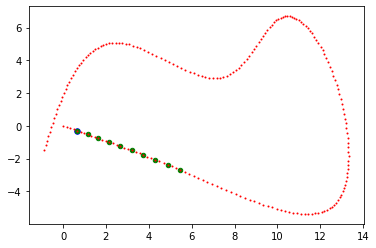

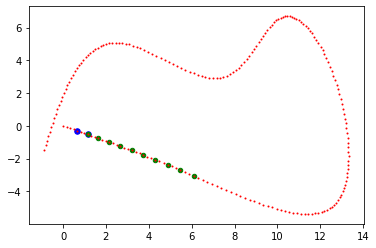

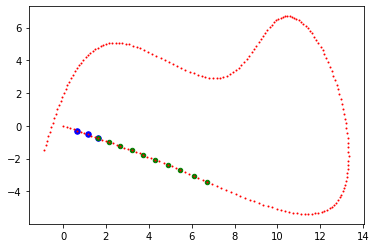

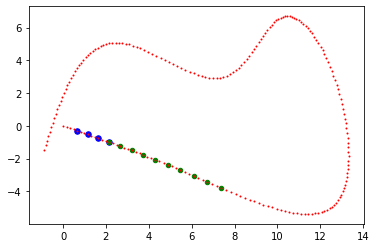

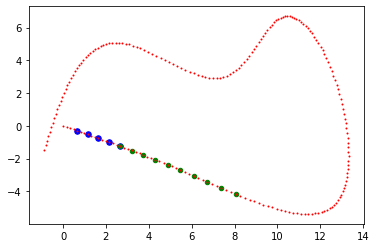

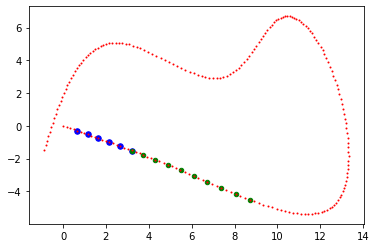

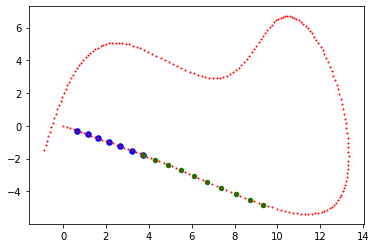

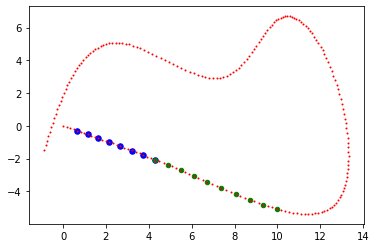

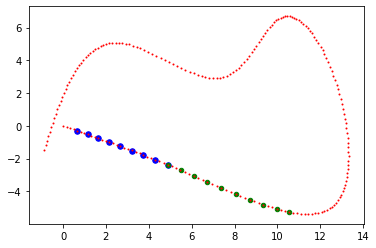

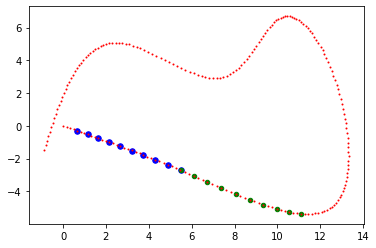

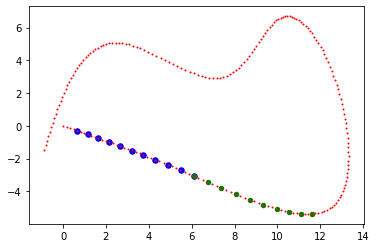

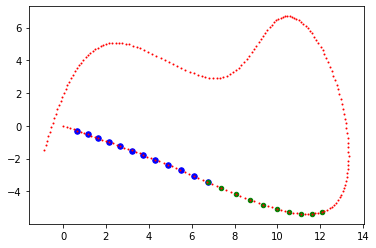

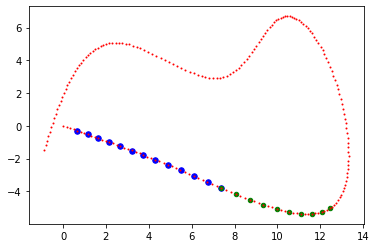

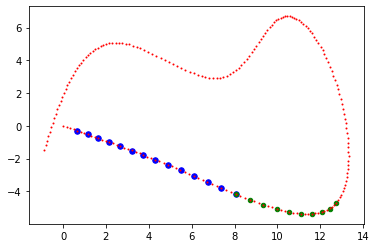

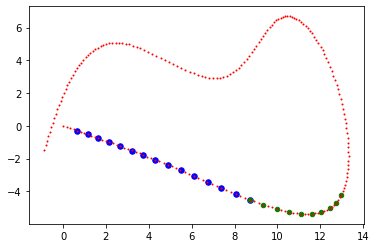

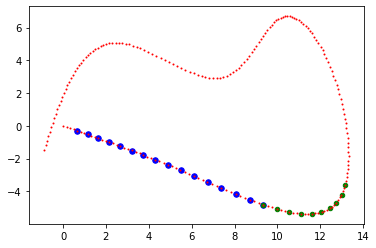

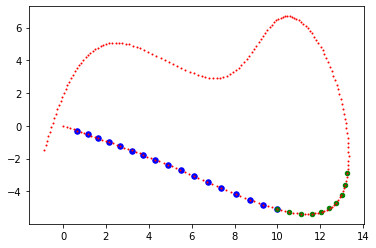

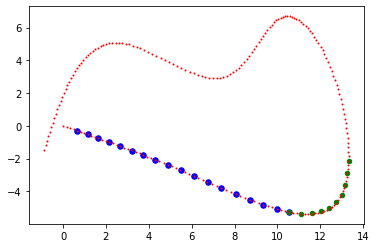

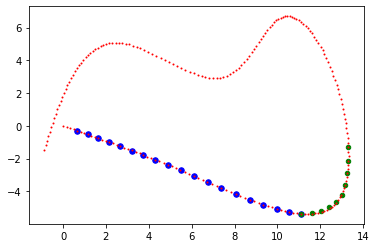

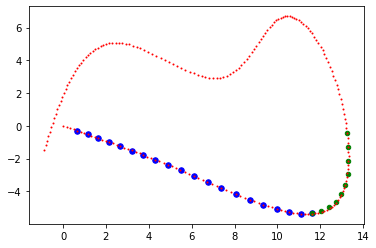

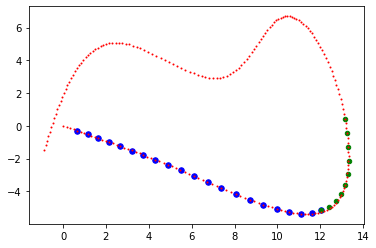

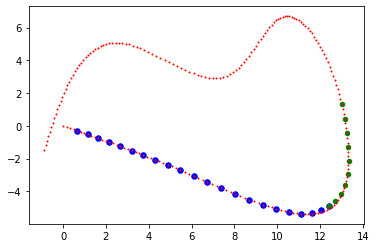

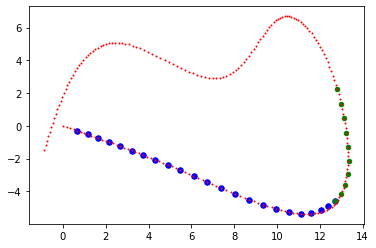

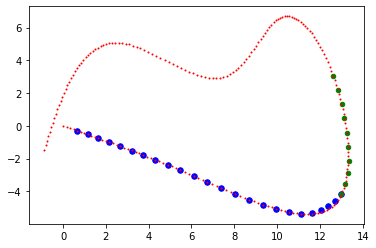

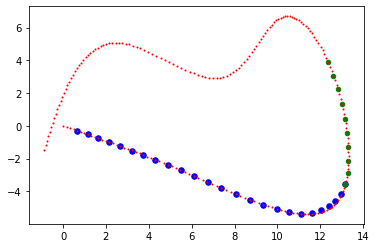

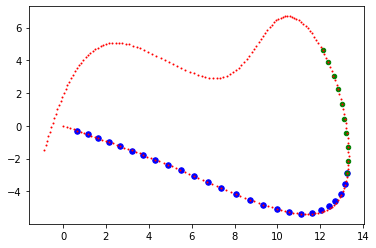

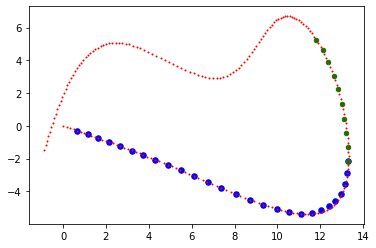

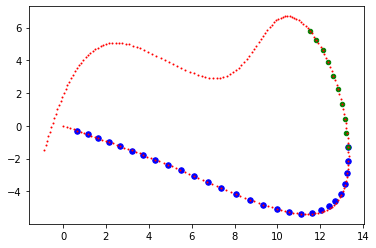

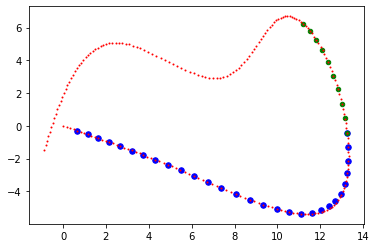

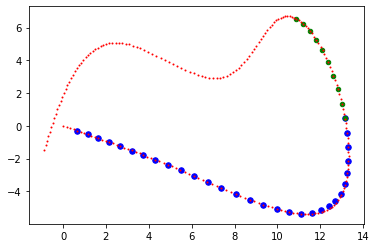

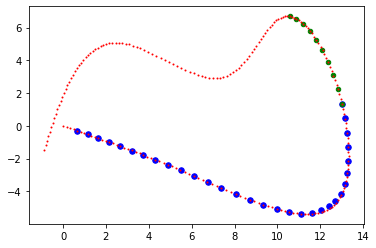

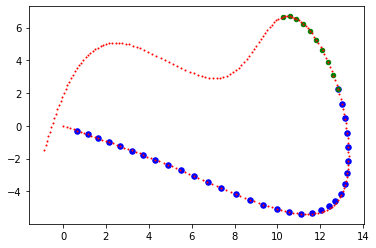

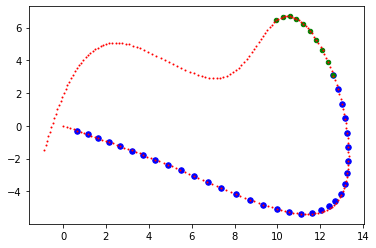

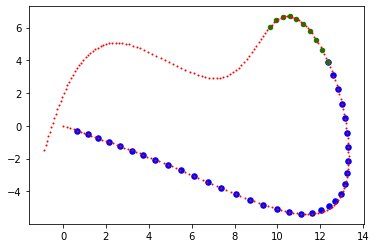

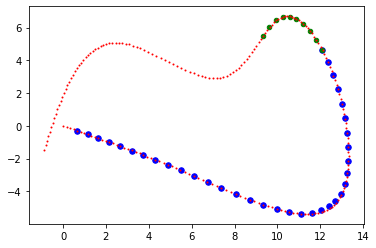

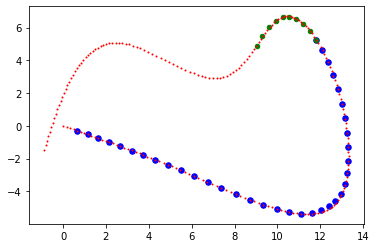

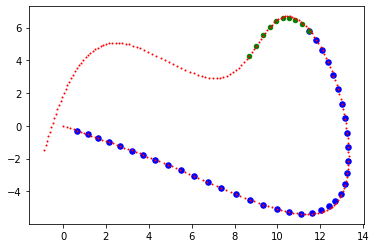

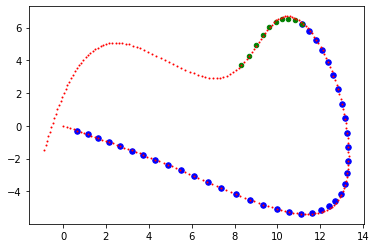

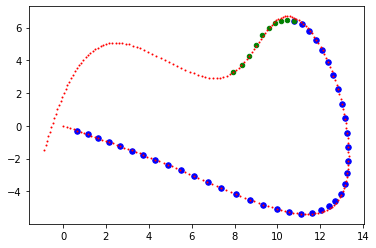

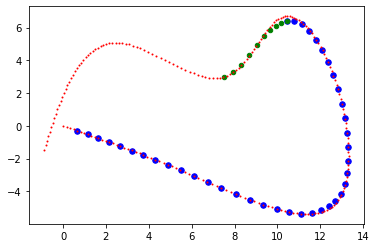

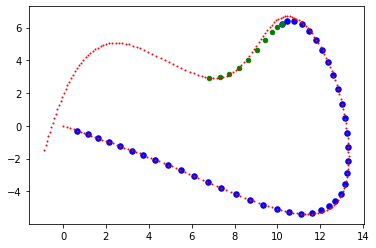

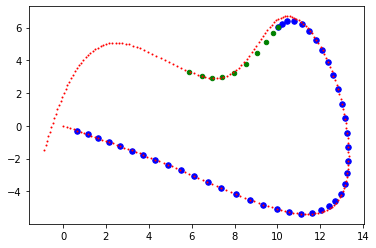

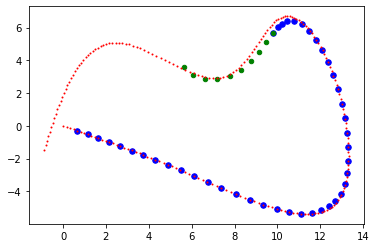

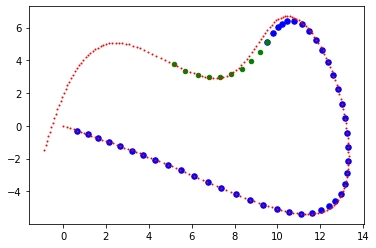

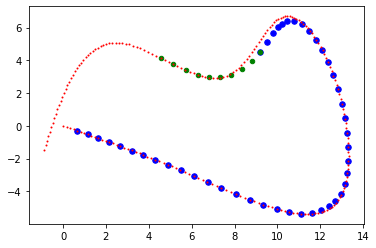

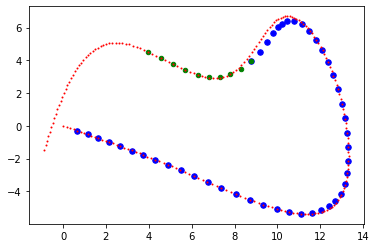

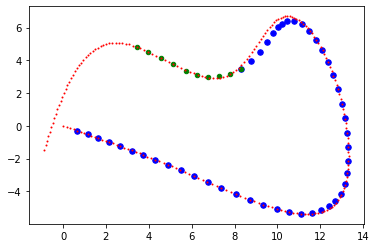

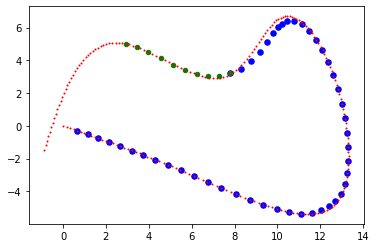

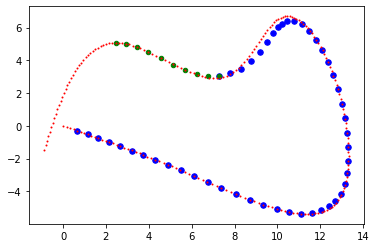

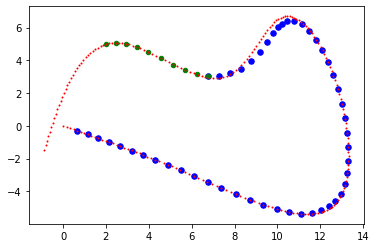

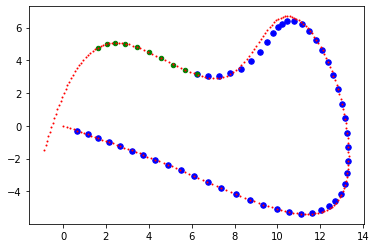

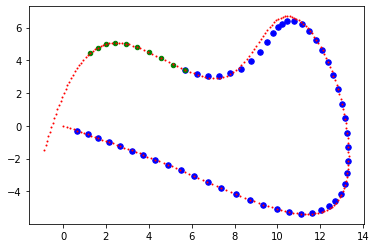

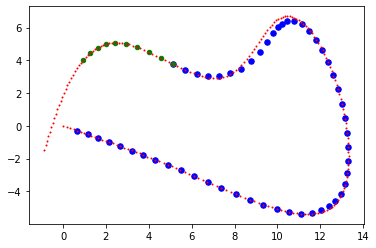

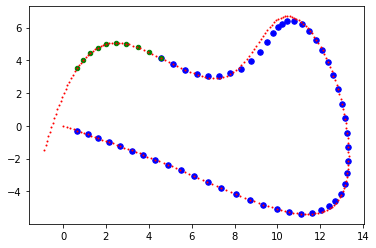

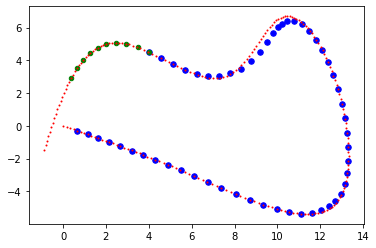

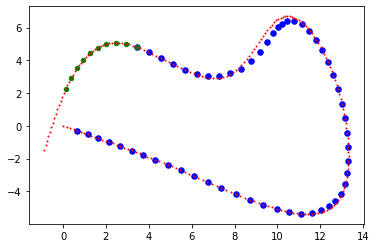

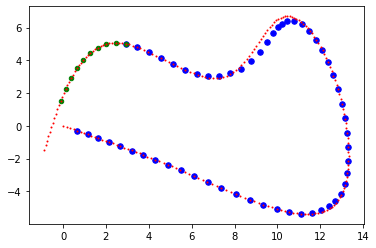

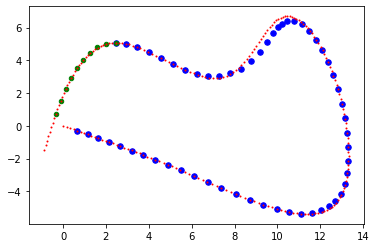

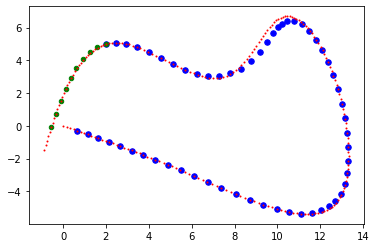

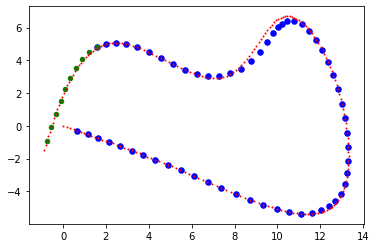

IndexError: index 212 is out of bounds for dimension 0 with size 212

In [8]:
# define gp_propagator (used to compute sequence of uncertainties of control accuracy)
gp_propagator = gaussian_propagator(p_model.forward,gp_model.forward,sigma_w)

# define initial state
x0,y0,gx0,gy0 = waypoints[start]
v0 = torch.sqrt(gx0.pow(2)+gy0.pow(2))*speed
yaw0 = torch.atan2(gy0,gx0)
delta0=torch.zeros(1)
a0=torch.zeros(1)
state0 = torch.cat( [x0.view(1),y0.view(1),yaw0.view(1),v0.view(1),delta0,a0])

# initialize estimate of uncertainty of control accuracy
vars0 = torch.ones(len_horizon)*0.1
_vars=vars0

# define first control input (not changing speed and steering angle) to be optimized later
_controls = torch.nn.Parameter(torch.zeros(len_horizon,2))

# define speed (constant velocity) 
dt = torch.ones(len_horizon,1)
vs = torch.LongTensor(torch.arange(len_horizon+1))*speed

real_path = []

for T in range(TMAX):
    if T>0:
        start = start_
        _controls = controls_.data.clone()
        
    # make prediction with MPC (inaccurate_model + gaussian_process)
    mpc = GP_MPC(gp_propagator,construct_loss_,len_horizon,waypoints)

    controls_dt,path,vars_ = mpc.run(state0,_controls,vs,dt,start,_vars)
    controls = controls_dt[:,:-1]
    
    # measure actual state 
    state_real = real_car_model.forward(state0,controls_dt[0])
    real_path.append(state_real.view(1,-1))

    controls_ = _controls.data.clone()
    controls_[:-(step+1)] = _controls[step+1:]
    controls_[-(step+1):]=0
    start_ = search_(state_real,waypoints,start,L=(speed+1)*len_horizon)
    
    state0 = state_real.data.clone()
    _vars = vars_.data.clone()
    
    # visualization
    _x = torch.cat(real_path,dim=0)[:,0].data.numpy()
    _y = torch.cat(real_path,dim=0)[:,1].data.numpy()
    
    x_ = path[:,0].data.numpy()
    y_ = path[:,1].data.numpy()
    
    plt.scatter(_x,_y,color='blue',s=30)
    plt.scatter(x_,y_,color='green',s=20)
    plt.scatter(cx,cy,color='red',s=1)
    im = plt.draw()
    s_zero = str(T).zfill(4)
    '''
    fn = "./figs/fig"+str(s_zero)+".png"
    plt.savefig(fn)
    '''
    plt.pause(0.01)

In [ ]:
#test